# 7.1 趋势跟踪与均值回复

## 7.1.1 趋势跟踪和均值回复的周期重叠性

In [5]:
import abupy
from abupy import ABuSymbolPd, ABuRegUtil
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
abupy.env.disable_example_env_ipython()

disable example env


In [6]:
kl_pd =ABuSymbolPd.make_kl_df('002584', n_folds=2)
kl_pd.tail()

,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14
2023-11-13,8.50,8.80,8.80,8.31,1694992,20231113,8.00,0,10.000,480,0.5826,0.6991
2023-11-14,7.92,8.90,9.60,7.92,2325828,20231114,8.80,1,1.136,481,0.6824,0.8299
2023-11-15,8.60,9.79,9.79,8.55,1841614,20231115,8.90,2,10.000,482,0.7331,0.8846
2023-11-16,9.30,10.77,10.77,9.00,1731598,20231116,9.79,3,10.010,483,0.8364,1.0160
2023-11-17,11.27,11.85,11.85,11.27,1417690,20231117,10.77,4,10.028,484,0.9477,1.1552


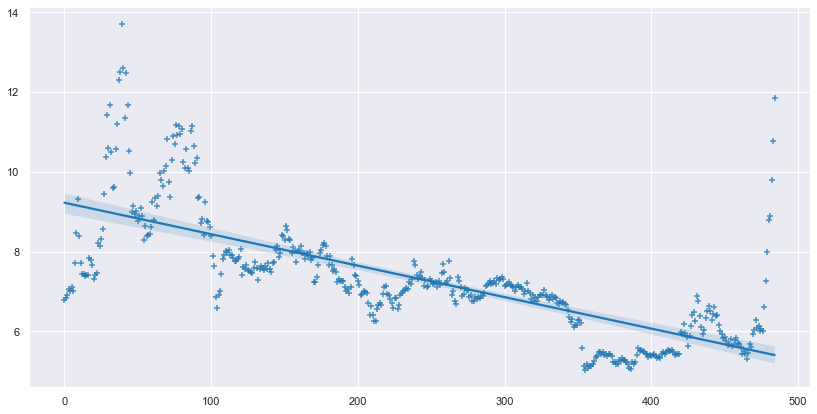

In [7]:
sns.set_context(rc={'figgure.figsize':(14,7)})
sns.regplot(x=np.arange(0, kl_pd.shape[0]), y=kl_pd.close.values, marker='+')
plt.show()

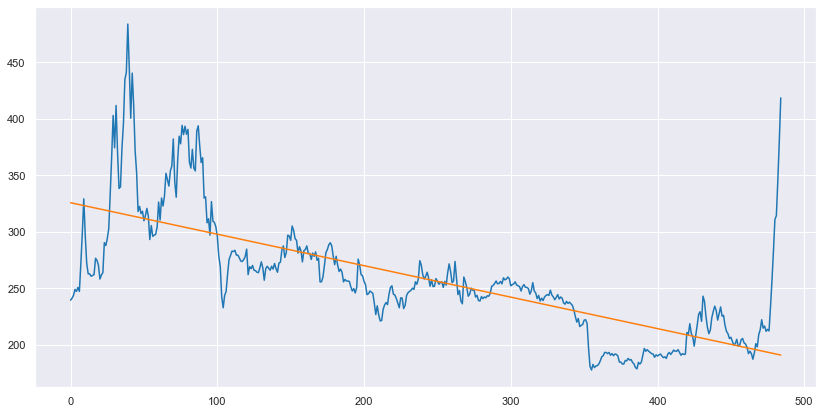

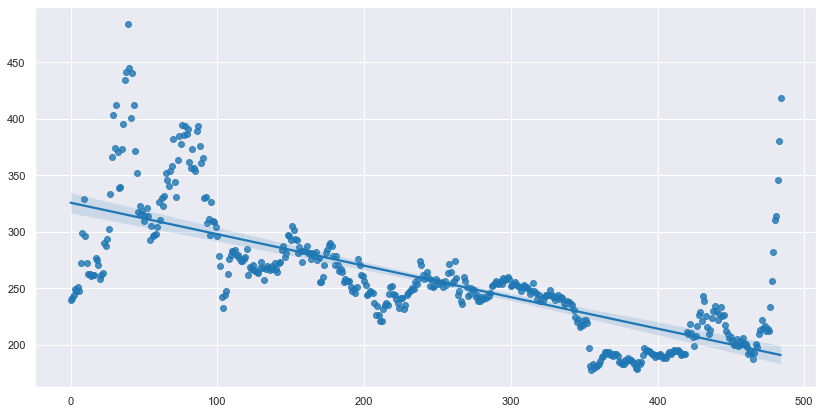

趋势角度:-15.966933395453063


In [8]:
deg = ABuRegUtil.calc_regress_deg(kl_pd.close.values)
print('趋势角度:' + str(deg))

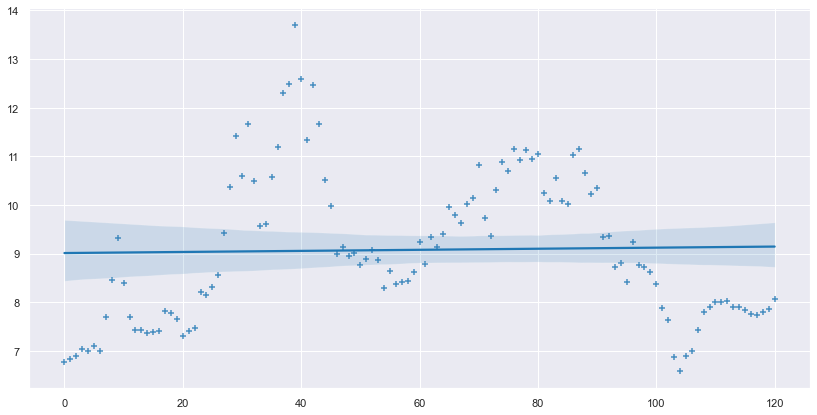

In [9]:
start = 0
end = int(kl_pd.shape[0] / 4)
x = np.arange(start, end)
y = kl_pd.close.values[start:end]
sns.regplot(x=x, y=y, marker='+')
plt.show()

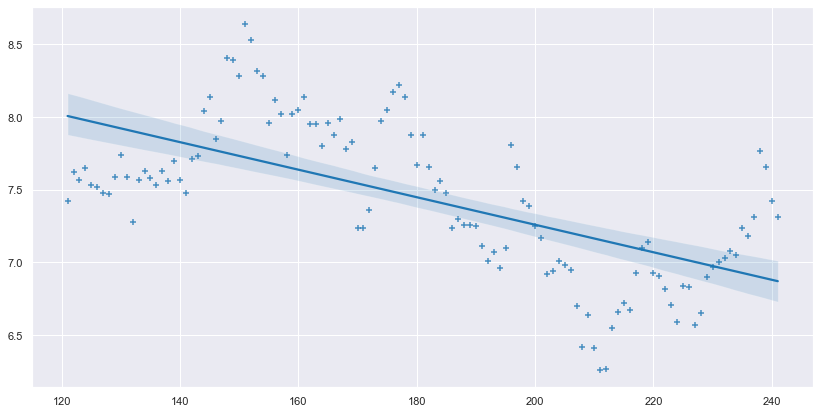

In [10]:
start = int(kl_pd.shape[0] / 4)
end = start + int(kl_pd.shape[0] / 4)
sns.regplot(x=np.arange(start, end), y=kl_pd.close.values[start:end], marker='+')
plt.show()

## 7.1.2 实例1:均值恢复策略
这里需要注意中国和美国市场的差异，美国交易日两年是，504天一半是252，中国是486天，一半改为243

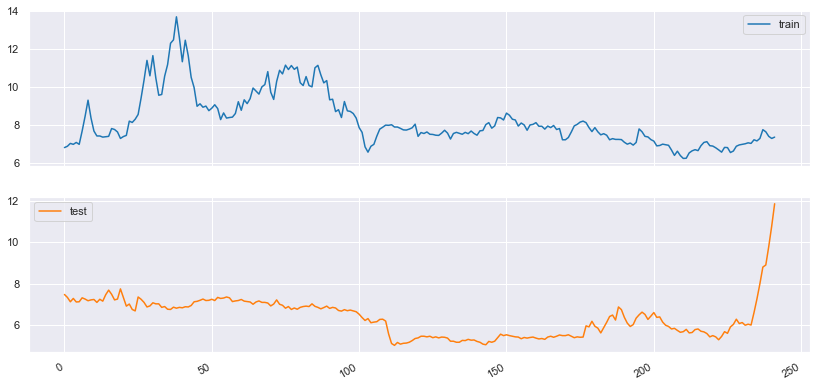

In [12]:
import pandas as pd
kl_pd = ABuSymbolPd.make_kl_df('002584', n_folds=2)
train_kl = kl_pd[1:243]
test_kl=kl_pd[243:]
# 数据展示在下面
tmp_df = pd.DataFrame(
    np.array([train_kl.close.values, test_kl.close.values]).T,
    columns=['train', 'test']
)
tmp_df[['train','test']].plot(subplots=True, grid=True, figsize=(14,7))
plt.show()

In [13]:
tmp_df = pd.DataFrame(
    np.array([train_kl.close.values, test_kl.close.values]).T,
    columns=['train', 'test']
)
print(tmp_df.head())
# print(np.array([train_kl.close.values, test_kl.close.values]))

   train  test
0   6.83  7.48
1   6.90  7.34
2   7.05  7.13
3   7.00  7.29
4   7.10  7.12


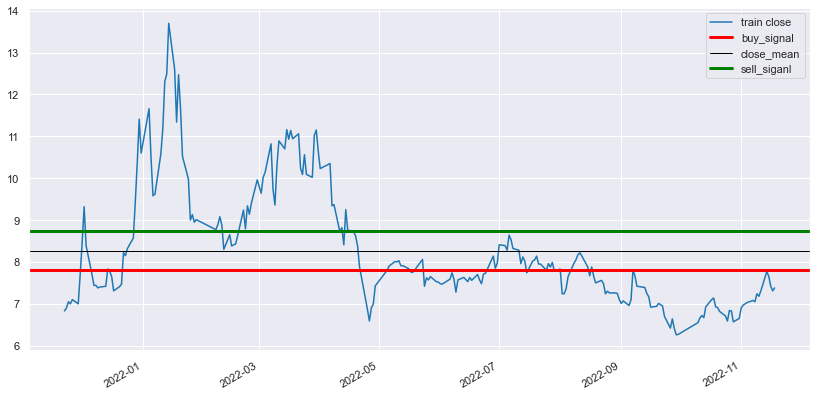

In [15]:
close_mean = train_kl.close.mean()
close_std = train_kl.close.std()
sell_signal = close_mean + close_std / 3
buy_signal = close_mean - close_std / 3
plt.figure(figsize=(14,7))
train_kl.close.plot()
plt.axhline(buy_signal, color='r', lw=3)
plt.axhline(close_mean, color='black', lw=1)
plt.axhline(sell_signal, color='g', lw=3)
plt.legend(['train close', 'buy_signal', 'close_mean', 'sell_siganl'], loc='best')
plt.show()

带入回归测试数据可视化

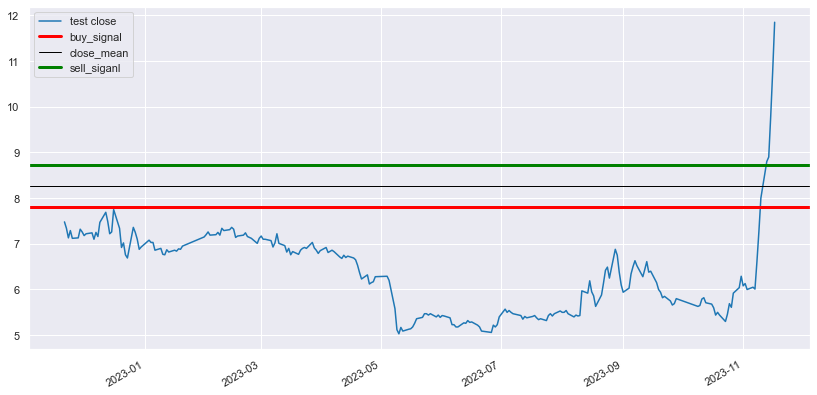

In [16]:
plt.figure(figsize=(14,7))
test_kl.close.plot()
plt.axhline(buy_signal, color='r', lw=3)
plt.axhline(close_mean, color='black', lw=1)
plt.axhline(sell_signal, color='g', lw=3)
plt.legend(['test close', 'buy_signal', 'close_mean', 'sell_siganl'], loc='best')
plt.show()

In [17]:
print('买入信号阀值{}, 卖出信号阀值{}'.format(buy_signal, sell_signal))

买入信号阀值7.7963406571632, 卖出信号阀值8.728865954407052


有了买卖的信号,将操作的信号,转为持股

In [18]:
buy_index = test_kl[test_kl['close'] < buy_signal].index
test_kl.loc[buy_index, 'signal'] = 1
test_kl[52:57]

,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14,signal
2023-02-09,7.17,7.34,7.44,7.15,253148,20230209,7.19,3,2.086,295,0.2013,0.1828,1.0
2023-02-10,7.36,7.29,7.37,7.25,147089,20230210,7.34,4,-0.681,296,0.1994,0.1824,1.0
2023-02-13,7.30,7.31,7.33,7.23,115720,20230213,7.29,0,0.274,297,0.1912,0.1728,1.0
2023-02-14,7.31,7.36,7.36,7.26,149152,20230214,7.31,1,0.684,298,0.1830,0.1631,1.0
2023-02-15,7.33,7.32,7.36,7.28,100733,20230215,7.36,2,-0.543,299,0.1736,0.1520,1.0


构建卖出信号 signal = 0

In [19]:
sell_index = test_kl[test_kl['close'] > sell_signal].index
test_kl.loc[sell_index, 'signal'] = 0
test_kl[48:53]

,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14,signal
2023-02-03,7.22,7.19,7.24,7.07,166031,20230203,7.26,4,-0.964,291,0.2185,0.1944,1.0
2023-02-06,7.16,7.20,7.26,7.14,124919,20230206,7.19,0,0.139,292,0.2095,0.1845,1.0
2023-02-07,7.20,7.25,7.25,7.16,147447,20230207,7.20,1,0.694,293,0.1987,0.1719,1.0
2023-02-08,7.25,7.19,7.30,7.17,150362,20230208,7.25,2,-0.828,294,0.1924,0.1663,1.0
2023-02-09,7.17,7.34,7.44,7.15,253148,20230209,7.19,3,2.086,295,0.2013,0.1828,1.0


将操作转化为持股

In [20]:
test_kl['keep'] = test_kl['signal']
test_kl['keep'].fillna(method='ffill', inplace=True)
test_kl[48:58]

,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14,signal,keep
2023-02-03,7.22,7.19,7.24,7.07,166031,20230203,7.26,4,-0.964,291,0.2185,0.1944,1.0,1.0
2023-02-06,7.16,7.20,7.26,7.14,124919,20230206,7.19,0,0.139,292,0.2095,0.1845,1.0,1.0
2023-02-07,7.20,7.25,7.25,7.16,147447,20230207,7.20,1,0.694,293,0.1987,0.1719,1.0,1.0
2023-02-08,7.25,7.19,7.30,7.17,150362,20230208,7.25,2,-0.828,294,0.1924,0.1663,1.0,1.0
2023-02-09,7.17,7.34,7.44,7.15,253148,20230209,7.19,3,2.086,295,0.2013,0.1828,1.0,1.0
2023-02-10,7.36,7.29,7.37,7.25,147089,20230210,7.34,4,-0.681,296,0.1994,0.1824,1.0,1.0
2023-02-13,7.30,7.31,7.33,7.23,115720,20230213,7.29,0,0.274,297,0.1912,0.1728,1.0,1.0
2023-02-14,7.31,7.36,7.36,7.26,149152,20230214,7.31,1,0.684,298,0.1830,0.1631,1.0,1.0
2023-02-15,7.33,7.32,7.36,7.28,100733,20230215,7.36,2,-0.543,299,0.1736,0.1520,1.0,1.0
2023-02-16,7.30,7.14,7.43,7.05,239266,20230216,7.32,3,-2.459,300,0.1924,0.1824,1.0,1.0


计算收益用于对比,使用两种方式来对比结算结果

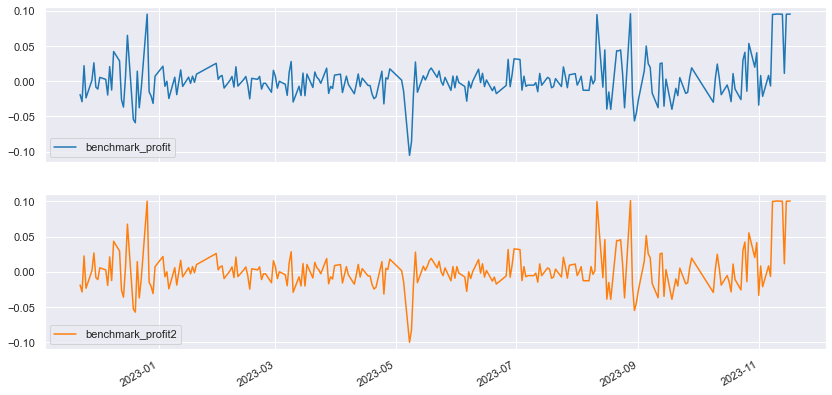

In [21]:
test_kl['benchmark_profit'] = np.log(test_kl['close']/test_kl['close'].shift(1))
test_kl['benchmark_profit2'] = test_kl['close']/test_kl['close'].shift(1) - 1
test_kl[['benchmark_profit', 'benchmark_profit2']].plot(subplots=True, grid=True, figsize=(14,7))
plt.show()

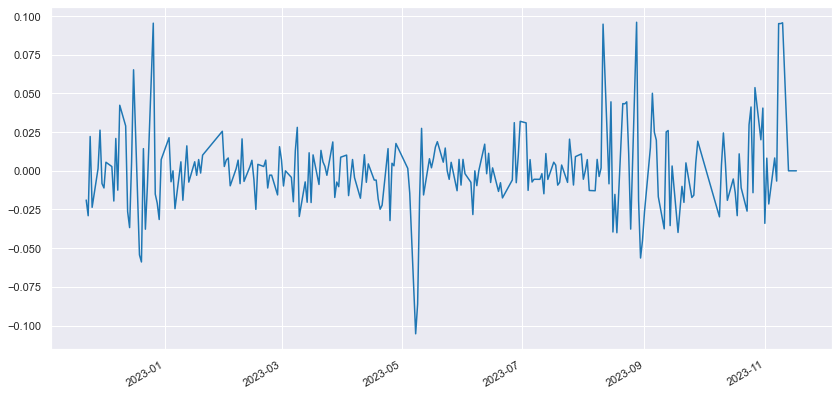

In [22]:
test_kl['trend_profit'] = test_kl['keep'] * test_kl['benchmark_profit']
test_kl['trend_profit'].plot(figsize=(14,7))
plt.show()

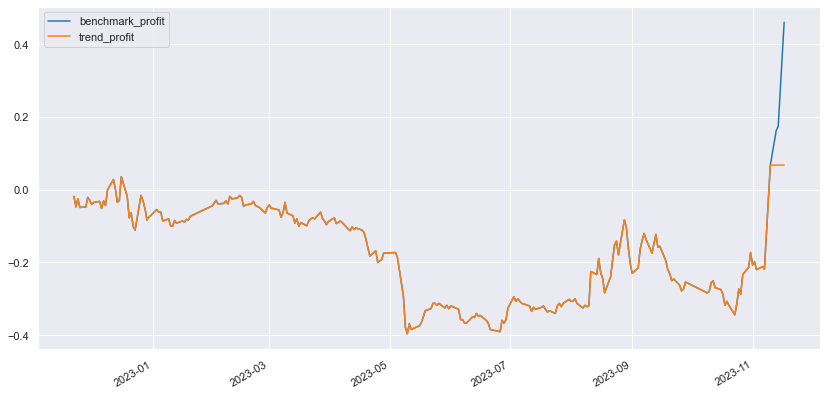

In [23]:
test_kl[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True, figsize=(14,7))
plt.show()

In [24]:
print('本金10万的回报20%, 10年后收益为:{}'.format(round(100000 * (1+0.2)**10)))
print('本金10万的回报30%, 10年后收益为:{}'.format(round(100000 * (1+0.3)**10)))

本金10万的回报20%, 10年后收益为:619174
本金10万的回报30%, 10年后收益为:1378585


# 7.1.3 实例2: 趋势跟踪策略

In [25]:
N1=42
N2=21
demo_list= np.array([1,2,1,1,100,1000])
pd.Series(demo_list).rolling(window=3).max()

0       NaN
1       NaN
2       2.0
3       2.0
4     100.0
5    1000.0
dtype: float64

In [27]:
# type(kl_pd['n1_high'])
# kl_pd['n1_high'] = pd.Series(kl_pd['high']).rolling(window=N1).max()
# kl_pd[0:5]

kl_pd['n1_high']  = kl_pd['high'].rolling(window=N1).max()
kl_pd[0:5]


,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14,n1_high
2021-11-19,6.16,6.78,6.78,6.11,487097,20211119,6.16,4,10.065,0,0.6700,0.6700,NaN
2021-11-22,6.95,6.83,6.99,6.63,658835,20211122,6.78,0,0.737,1,0.7538,0.7557,NaN
2021-11-23,6.71,6.90,7.24,6.69,484292,20211123,6.83,1,1.025,2,0.6793,0.6771,NaN
2021-11-24,6.90,7.05,7.20,6.83,447599,20211124,6.90,2,2.174,3,0.5906,0.5832,NaN
2021-11-25,7.01,7.00,7.14,6.95,294624,20211125,7.05,3,-0.709,4,0.5065,0.4936,NaN


In [28]:
pd.Series(demo_list).expanding(min_periods=1).max()



0       1.0
1       2.0
2       2.0
3       2.0
4     100.0
5    1000.0
dtype: float64

这个函数是从第一个数据开始,寻找列表中的最大值

In [29]:
expan_max= pd.Series(kl_pd['close']).expanding().max()
kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
kl_pd[0:5]

,open,close,high,low,volume,date,pre_close,date_week,p_change,key,atr21,atr14,n1_high
2021-11-19,6.16,6.78,6.78,6.11,487097,20211119,6.16,4,10.065,0,0.6700,0.6700,6.78
2021-11-22,6.95,6.83,6.99,6.63,658835,20211122,6.78,0,0.737,1,0.7538,0.7557,6.83
2021-11-23,6.71,6.90,7.24,6.69,484292,20211123,6.83,1,1.025,2,0.6793,0.6771,6.90
2021-11-24,6.90,7.05,7.20,6.83,447599,20211124,6.90,2,2.174,3,0.5906,0.5832,7.05
2021-11-25,7.01,7.00,7.14,6.95,294624,20211125,7.05,3,-0.709,4,0.5065,0.4936,7.05


In [30]:
kl_pd['n2_low']=pd.Series(kl_pd['low']).rolling(window=N2).min()
expan_min=pd.Series(kl_pd['close']).expanding().min()
kl_pd['n2_low'].fillna(value=expan_min, inplace=True)
# 根据突破的定义来构建signal列
buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
kl_pd.loc[buy_index, 'signal'] = 1
sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
kl_pd.loc[sell_index, 'signal'] = 0

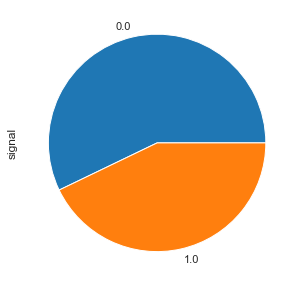

In [31]:
kl_pd.signal.value_counts().plot(kind='pie', figsize=(5,5))
plt.show()

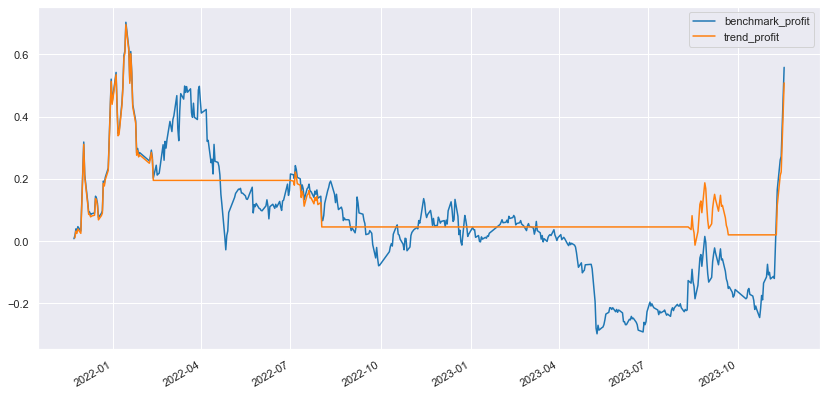

In [32]:
kl_pd['keep'] = kl_pd['signal'].shift(1)
kl_pd['keep'].fillna(method='ffill', inplace=True)
# 计算基准收益
kl_pd['benchmark_profit'] = np.log(kl_pd['close'] / kl_pd['close'].shift(1))
# 计算使用趋势突破策略的收益
kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']
# 可视化收益的情况对比
kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True, figsize=(14,7))
plt.show()

# 7.2 仓位控制管理

## 均值方差模型--需要深入了解

## 7.2.1 凯利公式

## 7.2.2 一支股票的时间简史

In [ ]:
# 第一阶段走势涵盖股票上市后前100天走势情况
trade_day = 100
# 这个股票第一阶段走势函数gen_stock_price_array()
def gen_stock_price_array():
    # 股票的初始价格为1 元钱
    price_array = np.ones(trade_day)
    
    # 以时间为驱动100个交易日, 生成100个交易日走势
    for ind in np.arange(0, trade_day - 1):
        if ind == 0:
            # 第一个交易日 50% 的概率结果是win
            win = np.random.binomial(1, 0.5)
        else:
            # 非第一日时它的涨跌幅与只与前一天的涨跌相关,如果前一天是上涨的,那么今天仍然上涨,如果前一天下跌,那么今天仍然下跌
            win = price_array[ind] > price_array[ind - 1]
            
        if win:
            # 每次上涨只能上涨5%
            price_array[ind + 1] = (1+0.05) * price_array[ind]
        else:
            price_array[ind+ 1] = (1- 0.05) * price_array[ind]
    return price_array

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
price_array1 = gen_stock_price_array()
price_array1_ex = gen_stock_price_array()
axs[0].plot(price_array1)
axs[1].plot(price_array1_ex)
plt.show()

第二种情况设定
如果连续上涨了3天,第4天及以后下跌的概率为55%
如果连续下跌了3天,第4天及以后上涨的概率为80%

In [ ]:
trade_day = 252
def gen_stock_price_array2():
    # np.concatenate 连接之前的100天走势和目前252的走势
    price_array = np.concatenate((price_array1, np.ones(trade_day) * price_array1[-1]), axis = 0)
    
    for ind in np.arange(len(price_array1) - 1, len(price_array) -1):
        # 获取当前叫日为基准的四个交易日数据
        last4 = price_array[ind - 3: ind + 1]
        if len(last4) == 4 and last4[-1] > last4[-2] and last4[-2] > last4[-3] and last4[-3] > last4[-4]:
            # 如果连续上涨了3天,第4天及以后下跌的概率为55%
            win = np.random.binomial(1, 0.45)
        elif len(last4) == 4 and last4[-1] < last4[-2] and last4[-2] < last4[-3] and last4[-3] < last4[-4]:
            # 如果连续下跌了3天,第4天及以后上涨的概率为80%
            win = np.random.binomial(1, 0.8)
        else:
            win = price_array[ind] > price_array[ind - 1]
            
        if win:
            price_array[ind + 1] = (1+0.05) * price_array[ind]
        else:
            price_array[ind + 1] = (1- 0.05) * price_array[ind]
    return price_array

import itertools
_, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
# 将 3 * 3 转为一个list
axs_list = list(itertools.chain.from_iterable(axs))
for ax in axs_list:
    ax.plot(gen_stock_price_array2())
plt.show()

In [ ]:
price_array2 = gen_stock_price_array2()
plt.plot(price_array2)
plt.show()

第三个条件加入:
如果股价连续下跌3天,第4天及以后存在系统性灾难概率,概率为20%,表现形式为股价下跌50%

In [ ]:
def gen_stock_price_array3():
    price_array = np.concatenate(
        (price_array2, np.ones(trade_day) * price_array2[-1]), axis=0
    )
    for ind in np.arange(len(price_array2)-1, len(price_array) - 1):
         # 获取当前叫日为基准的四个交易日数据
        last4 = price_array[ind - 3: ind + 1]
        if len(last4) == 4 and last4[-1] > last4[-2] and last4[-2] > last4[-3] and last4[-3] > last4[-4]:
            # 如果连续上涨了3天,第4天及以后下跌的概率为55%
            win = np.random.binomial(1, 0.45)
        elif len(last4) == 4 and last4[-1] < last4[-2] and last4[-2] < last4[-3] and last4[-3] < last4[-4]:
            # 如果连续下跌了3天,第4天及以后上涨的概率为80%
            win = np.random.binomial(1, 0.8)
            if not win:
                price_array[ind+1] = (1-0.5) * price_array[ind]
                continue
        else:
            win = price_array[ind] >= price_array[ind - 1]
            
        if win:
            price_array[ind + 1] = (1+0.05) * price_array[ind]
        else:
            price_array[ind + 1] = (1- 0.05) * price_array[ind]
        # 股价小于0.1,股价归0 退出市场
        if price_array[ind + 1] <=0.1:
            price_array[ind + 1:] = 0
            break
    return price_array


## 7.2.3 三只小猪股票投资的故事

In [ ]:
trade_day = 252 * 3
price_array3 = gen_stock_price_array3()
plt.plot(price_array3)
plt.show()

In [ ]:
def execute_trade(cash, buy_rate):
    commission=5
    stock_cnt = 0
    keep_day = 0
    capital =[]
    for ind in np.arange(352, len(price_array3) - 1):
        if stock_cnt > 0:
            keep_day +=1
        if stock_cnt > 0 and keep_day == 3:
            cash += price_array3[ind] * stock_cnt
            cash -= commission
            if cash <=0:
                capital.append(0)
                print('爆仓了')
                break
            keep_day = 0
            stock_cnt = 0
        # 获取当前交易日为基准5个交易日数据,5个交易日价格到4个交易日的涨跌情况
        last5 = price_array3[ind - 4: ind +1]
        # 买入条件 example:last5 = [82.4, 86.5 82.2 81.1 74.3]
        # 1.持有股票 stock_cnt = 0
        # 2.last5 第一个交易日上涨,后面三个下跌
        if stock_cnt == 0 and len(last5) == 5 and last5[1] > last5[0] and last5[-1] < last5[-2] and last5[-2] < last5[-3] and last5[-3] < last5[-4]:
            cash -= commission
            # 按照资金仓位管理buy_rate买入
            buy_cash = (cash * buy_rate)
            cash -= buy_cash
            stock_cnt += buy_cash / price_array3[ind]
            
            if stock_cnt < 1:
                captial.append(0)
                print('爆仓了')
                break
            keep_day = 0
        capital.append(cash + (stock_cnt* price_array3[ind]))
    return capital

# 第一个小猪投资
pig_one_cash = 10000
buy_rate = 1.0
pig_one_capital = execute_trade(pig_one_cash, buy_rate)
print('猪老大最终资产{}'.format(pig_one_capital[-1]))
print('猪老大资产最高峰值{}'.format(max(pig_one_capital)))
plt.plot(pig_one_capital)
plt.show()


猪老二 buy_rate = 0.6 最终资产为7665

In [ ]:
pig_two_cash = 10000
buy_rate = 0.6
pig_two_capital= execute_trade(pig_two_cash, buy_rate)
print('猪老二最终资产{}'.format(pig_two_capital[-1]))
print('猪老二资产最高峰值{}'.format(max(pig_two_capital)))
plt.plot(pig_two_capital)
plt.show()

猪老三 buy_rate = 0.13 最终资产

In [ ]:
pig_three_cash = 10000
buy_rate = 0.8 - 0.2 / (0.15 / 0.5)
pig_three_capital= execute_trade(pig_three_cash, buy_rate)
print('猪老三最终资产{}'.format(pig_three_capital[-1]))
print('猪老三资产最高峰值{}'.format(max(pig_three_capital)))
plt.plot(pig_three_capital)
plt.show()